In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import wget
import os
from scipy.stats import chi2
from scipy.stats import t
from tqdm import tqdm
import sympy as sym
import corner

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
mean = np.mean(sample)
print(mean)

0.9484999999999999


In [4]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size = len(sample), replace = True )
    return resample_

In [5]:
np.mean(Resample(sample))

0.9101000000000001

In [6]:
def Bootstrapping(sample,N=10000):
    
    Mean_Dist = np.zeros(N)
    
    for i in tqdm(range(N)):
        resample = Resample(sample)
        Mean_Dist[i] = np.mean(resample)
        
    return Mean_Dist

In [7]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10035.59it/s]


In [8]:
mean = np.percentile(Mean_Dist,50)
print(mean)
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84] )
q2 = np.quantile( a = Mean_Dist, q=[0.023,0.977] )

q1

0.9479


array([0.925, 0.972])

In [9]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10186.51it/s]


In [10]:
errorinf = mean-q1[0]
errorsup = q1[1] - mean
print(errorinf,errorsup)

0.02289999999999992 0.0240999999999999


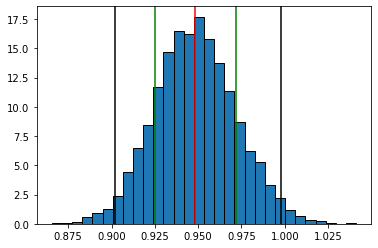

In [11]:
plt.hist(Mean_Dist, bins=30, density=True, ec='k')
plt.axvline(x=mean,color='r')
plt.axvline(x=q1[0],color='g')
plt.axvline(x=q1[1],color='g')
plt.axvline(x=q2[0],color='k')
plt.axvline(x=q2[1],color='k')

$$ \hat{\mu} = 0.948_{0.022}^{0.023}  at 68\% CL $$

In [12]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 521 / 521File loaded


In [13]:
Data = np.loadtxt(Path_)

In [14]:
x = Data[:,0]
y = Data[:,1]
N = len(x)
sigma = np.random.uniform(1,4,size=N)
sigma

array([3.92347929, 3.82864882, 3.21973599, 3.27702077, 1.3827553 ,
       1.77481424, 3.15184969, 1.68490107, 2.79803195, 1.52319468,
       2.77762753, 1.32900735, 1.37986798, 2.55121   , 2.70560882,
       2.58441468, 1.69863625, 3.06244426, 3.8834191 , 1.24603034])

In [15]:
def GetFit(x,y,n=3):
    
    size = len(x)
    b = y
    
    A = np.ones((size,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**(i)

    # Hacer ajuste cuadratico
    
    M = np.dot(A.T,A)
    bt = np.dot(A.T,b)
    
    xsol = np.linalg.solve(M,bt)

    return xsol

In [16]:
n = 3 # order of the polynomial
param = GetFit(x,y,n=n)
print(param)

[ 2.51399562  4.3071984   3.41409299 -0.03050037]


In [17]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
    
    return y

In [18]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

-0.030500372881491*x**3 + 3.41409299223471*x**2 + 4.3071984013719*x + 2.51399562194949

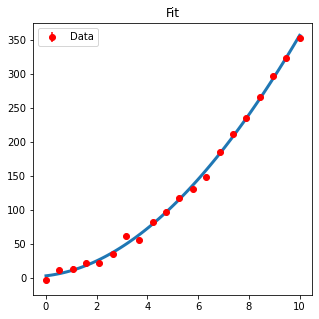

In [19]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')
ax.plot(t,GetModel(t,param),lw=3) 
#ax.plot(t,GetModel(t,param), label="Parameters: {0}".format(np.round(param,2))) 
ax.legend(loc=0)

In [20]:
def GetChi2(x,y,sigma,p,reducido=True):
    
    df = (len(x) - len(p) - 1) 
    
    if not reducido:
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) , df
    else:   
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) / df ,df

In [21]:
param = GetFit(x,y,n)
Chi2,df = GetChi2(x,y,sigma,param)
print(Chi2)

10.652853010194322


# Bootstraping

In [22]:
dict1 = dict(zip(x,y))
#dict1

In [23]:
def GetBootstrapping(x,n=3,Ntrials=int(3e4)):
    
    Values = np.zeros( (Ntrials, n+1) )
    
    for i in tqdm(range(Ntrials)):
        
        x1 = Resample(x)
        
        y1 = np.array([])
        
        for j in x1:
            y1 = np.append(y1,dict1[j])
            
        p = GetFit(x1,y1,n)
        
        Values[i] = p
        
    return Values

In [24]:
Mean_Dist = GetBootstrapping(x,n=n)

100%|███████████████████████████████████████████████████████| 30000/30000 [00:17<00:00, 1676.59it/s]


[ 2.30584568  4.2863554   3.43285842 -0.0317871 ]


Text(0.5, 0, 'step number')

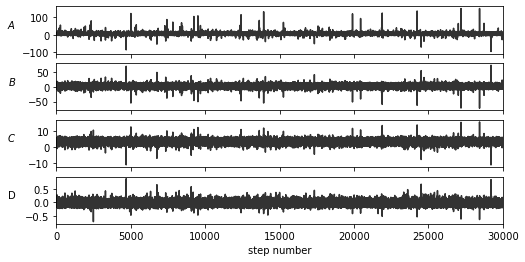

In [26]:
params = np.percentile(Mean_Dist,50,axis=0)
print(params)
fig, axes = plt.subplots(len(params), figsize=(8, 4), sharex=True)
labels = ["$A$","$B$","$C$","D"]
for i in range(len(params)):
    ax = axes[i]
    ax.plot(Mean_Dist[:,i], 'k', alpha=0.8)
    ax.set_xlim(0, len(Mean_Dist))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

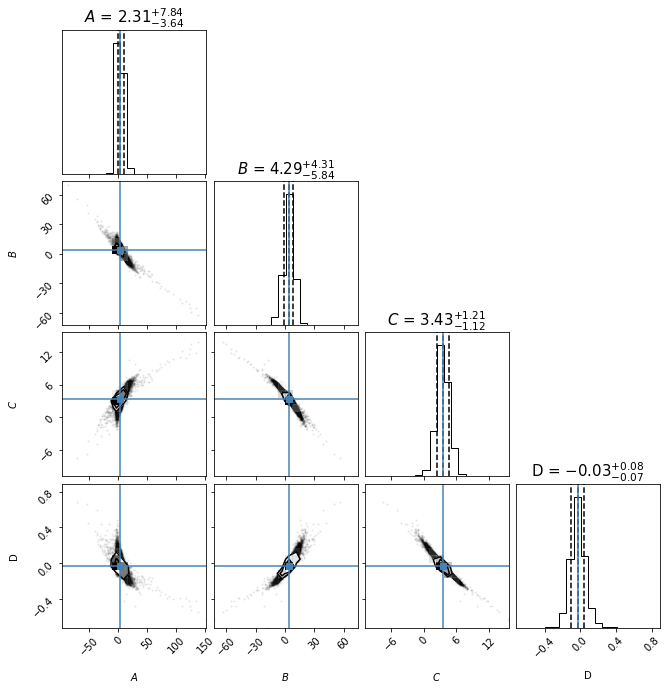

In [27]:
truths = np.percentile(Mean_Dist,50, axis=0)
figure = corner.corner(Mean_Dist, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

In [28]:
mean = np.percentile(Mean_Dist, 50, axis=0 )
mean

array([ 2.30584568,  4.2863554 ,  3.43285842, -0.0317871 ])

In [29]:
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84], axis=0 )
q1

array([[-1.3352146 , -1.55707106,  2.31683019, -0.10501421],
       [10.14616871,  8.60033234,  4.64556903,  0.0447935 ]])

In [30]:
errorsup = q1[1] - mean
errorinf = mean - q1[0]
print(errorsup)
print(errorinf)

[7.84032303 4.31397694 1.2127106  0.0765806 ]
[3.64106028 5.84342646 1.11602824 0.07322711]


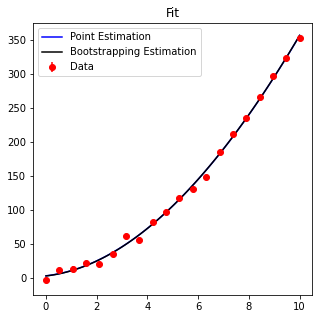

In [31]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')


ax.plot(t,GetModel(t,param),color='b', label='Point Estimation') 
bootsparam=[i for i in mean]
ax.plot(t,GetModel(t,bootsparam),color='k', label='Bootstrapping Estimation') 
ax.legend(loc=0)

<ErrorbarContainer object of 3 artists>

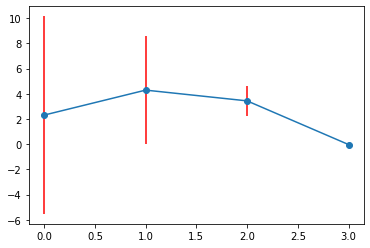

In [32]:
p1 = np.arange(0,len(mean),1)
plt.errorbar(p1,mean,yerr=errorsup,marker='o',ecolor='r')

# Varianza

In [34]:
A = np.ones((len(x),n+1))

for i in range(1,n+1):
    A[:,i] = x**i



In [35]:
MR = y - np.dot(A,mean)
sigma2 = np.dot( MR.T, MR )/(N-len(mean))
sigma2

34.078008142743236

In [36]:
Var = sigma2*np.linalg.inv(np.dot(A.T,A))
Var

array([[ 1.91614243e+01, -1.39233657e+01,  2.70911531e+00,
        -1.53979633e-01],
       [-1.39233657e+01,  1.51380784e+01, -3.43974104e+00,
         2.12451636e-01],
       [ 2.70911531e+00, -3.43974104e+00,  8.42747341e-01,
        -5.44967129e-02],
       [-1.53979633e-01,  2.12451636e-01, -5.44967129e-02,
         3.63311422e-03]])

In [37]:
for i in range(len(mean)):
    print(np.sqrt(Var[i,i]))

4.377376422798303
3.8907683521879606
0.9180127131107215
0.06027532013360884


In [38]:
mean

array([ 2.30584568,  4.2863554 ,  3.43285842, -0.0317871 ])

In [44]:
tobs = (0 - mean[-1])/Var[-1,-1]
tobs

8.749271505718106

In [39]:
from scipy.stats import t
df = N - len(mean) - 1
tcritico =  t.ppf(0.975,df=df)
tcritico

2.131449545559323

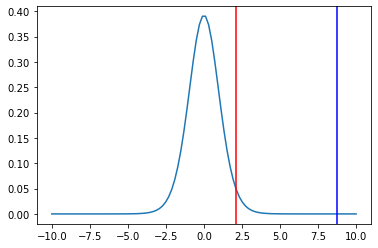

In [45]:
x = np.linspace(-10,10,100)
plt.plot(x,t.pdf(x,df=df))
plt.axvline(x=tcritico,color='r')
plt.axvline(x=tobs,color='b')

In [49]:
pvalue = 1 - t.cdf(tobs,df=df)
pvalue

1.4055899810738737e-07

In [51]:
from scipy.stats import norm
norm.ppf(pvalue)

-5.135685125552221